In [1]:
import sys
sys.path.insert(0, './src/yelp_prediction')

In [2]:
import polars as pl
import dataframes as df
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [3]:
(df_businesses, df_exact_stars, df_photos_per_business, df_photos) = pl.collect_all(
    (
        df.q_businesses,
        df.q_exact_stars,
        df.q_photos_agg,
        df.q_photos
    )
)

In [4]:
predictions = pl.read_csv("data/predictions.csv")
display(predictions)

epoch,photo_id,prediction
i64,str,f64
1,"""DbGUSoaJwDf8T0OCAwu2ug""",3.968435
1,"""3rxg0aqK_lH7bk791iLs3A""",2.622132
1,"""afF7vRHSKY--Mu-TeNOj7w""",2.843358
1,"""4cxe3BxSBjs0Mpb2RM1aiQ""",2.889756
1,"""C1mxBzo9STo_8cb5cJpRAQ""",2.71041
…,…,…
20,"""JqWU89NsI_vWoRZLJ4y1hw""",3.593001
20,"""KR9YgbtHSIrvZoRMD0coqg""",3.821944
20,"""hPQrMaKDq4x11o3ZL0yvfg""",3.696661


In [5]:
table = (
    df_photos.join(predictions, on="photo_id")
    .join(df_exact_stars, on="business_id")
    .join(df_businesses, on="business_id")
    .join(df_photos_per_business, on="business_id")
    .select(
        pl.col("epoch"),
        pl.col("photo_id"),
        pl.col("business_id"),
        pl.col("photo_count").alias("business_photo_count"),
        pl.col("label"),
        pl.col("review_count").alias("business_review_count"),
        pl.col("prediction"),
        pl.col("exact_stars").alias("actual"),
    )
    .with_columns(
        (pl.col("prediction") - pl.col("actual")).alias("error"),
    )
    .with_columns(
        pl.col("error").abs().alias("abs_error"),
    )
)

display(table)

epoch,photo_id,business_id,business_photo_count,label,business_review_count,prediction,actual,error,abs_error
i64,str,str,u32,str,i64,f64,f64,f64,f64
1,"""DbGUSoaJwDf8T0OCAwu2ug""","""W3o90EwU1jw3k64ol-uLBA""",1,"""inside""",21,3.968435,4.173913,-0.205478,0.205478
1,"""3rxg0aqK_lH7bk791iLs3A""","""iivbJVE6W4pUXcLrWhc1og""",4,"""food""",20,2.622132,2.0,0.622132,0.622132
1,"""afF7vRHSKY--Mu-TeNOj7w""","""iivbJVE6W4pUXcLrWhc1og""",4,"""food""",20,2.843358,2.0,0.843358,0.843358
1,"""4cxe3BxSBjs0Mpb2RM1aiQ""","""iivbJVE6W4pUXcLrWhc1og""",4,"""food""",20,2.889756,2.0,0.889756,0.889756
1,"""C1mxBzo9STo_8cb5cJpRAQ""","""iivbJVE6W4pUXcLrWhc1og""",4,"""food""",20,2.71041,2.0,0.71041,0.71041
…,…,…,…,…,…,…,…,…,…
20,"""JqWU89NsI_vWoRZLJ4y1hw""","""DGvkU7CkdBs6lNbncQmF3A""",6,"""drink""",129,3.593001,3.628571,-0.035571,0.035571
20,"""KR9YgbtHSIrvZoRMD0coqg""","""DGvkU7CkdBs6lNbncQmF3A""",6,"""food""",129,3.821944,3.628571,0.193372,0.193372
20,"""hPQrMaKDq4x11o3ZL0yvfg""","""DGvkU7CkdBs6lNbncQmF3A""",6,"""food""",129,3.696661,3.628571,0.068089,0.068089


In [6]:
table_by_epoch = (
    table.group_by("epoch")
    .agg(
        pl.col("abs_error").mean().alias("mae"),
        pl.col("error").pow(2).mean().alias("mse"),
    )
    .with_columns(
        pl.col("mse").sqrt().alias("rmse"),
    )
    .sort("epoch")
)

display(table_by_epoch)


epoch,mae,mse,rmse
i64,f64,f64,f64
1,0.390248,0.264334,0.514135
2,0.383449,0.255641,0.50561
3,0.384864,0.261344,0.511218
4,0.381037,0.254069,0.504052
5,0.379732,0.250666,0.500666
…,…,…,…
16,0.385004,0.257801,0.507741
17,0.384111,0.256728,0.506683
18,0.3835,0.256281,0.506242


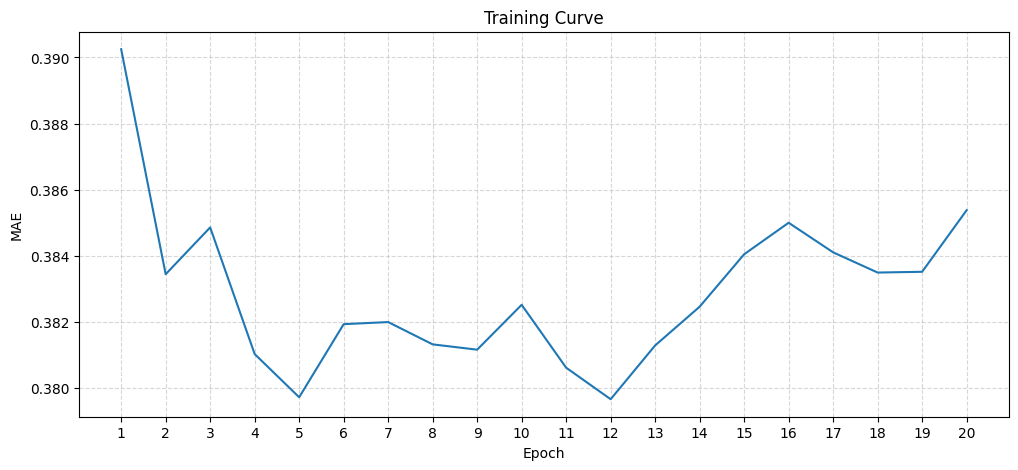

In [7]:
plt.figure(figsize=(12, 5))
plt.plot(
    table_by_epoch["epoch"],
    table_by_epoch["mae"],
)
plt.title("Training Curve")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.xticks(range(1, 21))
plt.grid(True, which="both", ls="--", alpha=0.5)

In [8]:
def _get_best_table_by(col: str):
    best_epoch = table_by_epoch.sort(by=col).slice(0, 1).select("epoch").item()
    best_epoch_table = table.filter(pl.col("epoch") == best_epoch).drop("epoch")
    return best_epoch, best_epoch_table


best_epoch, best_epoch_table = _get_best_table_by("mae")
display(best_epoch_table)

photo_id,business_id,business_photo_count,label,business_review_count,prediction,actual,error,abs_error
str,str,u32,str,i64,f64,f64,f64,f64
"""DbGUSoaJwDf8T0OCAwu2ug""","""W3o90EwU1jw3k64ol-uLBA""",1,"""inside""",21,4.088645,4.173913,-0.085268,0.085268
"""3rxg0aqK_lH7bk791iLs3A""","""iivbJVE6W4pUXcLrWhc1og""",4,"""food""",20,2.30177,2.0,0.30177,0.30177
"""afF7vRHSKY--Mu-TeNOj7w""","""iivbJVE6W4pUXcLrWhc1og""",4,"""food""",20,2.392804,2.0,0.392804,0.392804
"""4cxe3BxSBjs0Mpb2RM1aiQ""","""iivbJVE6W4pUXcLrWhc1og""",4,"""food""",20,2.661564,2.0,0.661564,0.661564
"""C1mxBzo9STo_8cb5cJpRAQ""","""iivbJVE6W4pUXcLrWhc1og""",4,"""food""",20,2.585625,2.0,0.585625,0.585625
…,…,…,…,…,…,…,…,…
"""JqWU89NsI_vWoRZLJ4y1hw""","""DGvkU7CkdBs6lNbncQmF3A""",6,"""drink""",129,3.697688,3.628571,0.069116,0.069116
"""KR9YgbtHSIrvZoRMD0coqg""","""DGvkU7CkdBs6lNbncQmF3A""",6,"""food""",129,3.796001,3.628571,0.16743,0.16743
"""hPQrMaKDq4x11o3ZL0yvfg""","""DGvkU7CkdBs6lNbncQmF3A""",6,"""food""",129,3.747795,3.628571,0.119224,0.119224


In [9]:
best_epoch_table_grouped = best_epoch_table.group_by("business_id").agg(
    abs_error=pl.col("abs_error").mean(),
    actual=pl.col("actual").first(),
)

best_epoch_table_grouped

business_id,abs_error,actual
str,f64,f64
"""I-Kn6FzE4wqX4CF3dUa7cw""",0.445059,4.754545
"""P1CqS7VKYDtjh3eR_gTx-w""",0.148299,4.144828
"""7pN4cTiJ73R1K2jc410pWA""",0.181509,4.044586
"""dGeXdSMah56gEHwZNaRQKA""",0.270799,3.575099
"""1LUZupYFJ6CxSKU37qDSXw""",0.314955,3.57513
…,…,…
"""Q0YscPA7X4RUg130LulYLA""",0.664541,2.736842
"""k7ESc-3Odp6t9-V17YDipA""",0.321467,4.239437
"""kwtKZ3fzM5jlR8Z7KIA17g""",0.933344,4.8


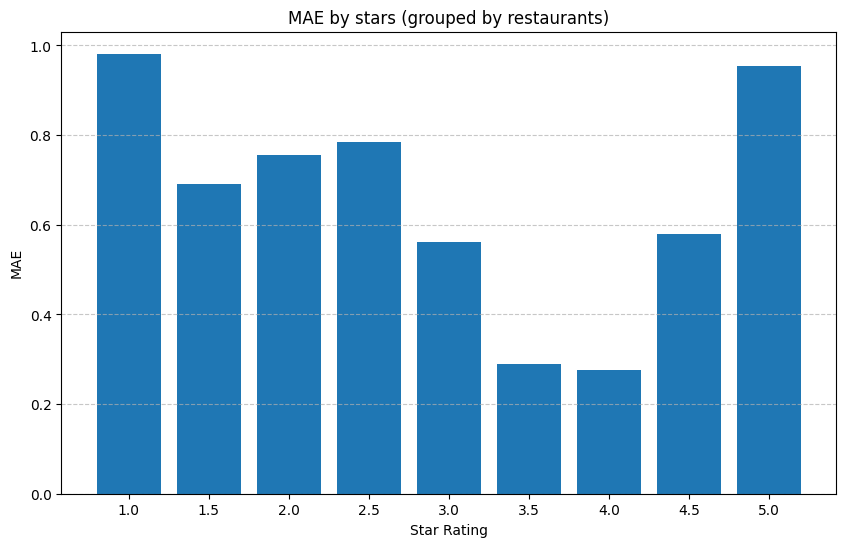

In [10]:
step_size = 0.5
floored_stars_q = (pl.col("actual") / step_size).floor() * step_size
grouped = (
    best_epoch_table_grouped.group_by(floored_stars_q.alias("stars"))
    .agg(
        pl.col("abs_error").mean().alias("mae"),
        pl.col("abs_error").pow(2).mean().alias("mse"),
    )
    .sort("stars")
)

plt.figure(figsize=(10, 6))
plt.bar(
    x=grouped["stars"],
    height=grouped["mae"],
    width=0.4,
)
plt.title("MAE by stars (grouped by restaurants)")
plt.xlabel("Star Rating")
plt.ylabel("MAE")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks([x/2+1 for x in range(9)]);

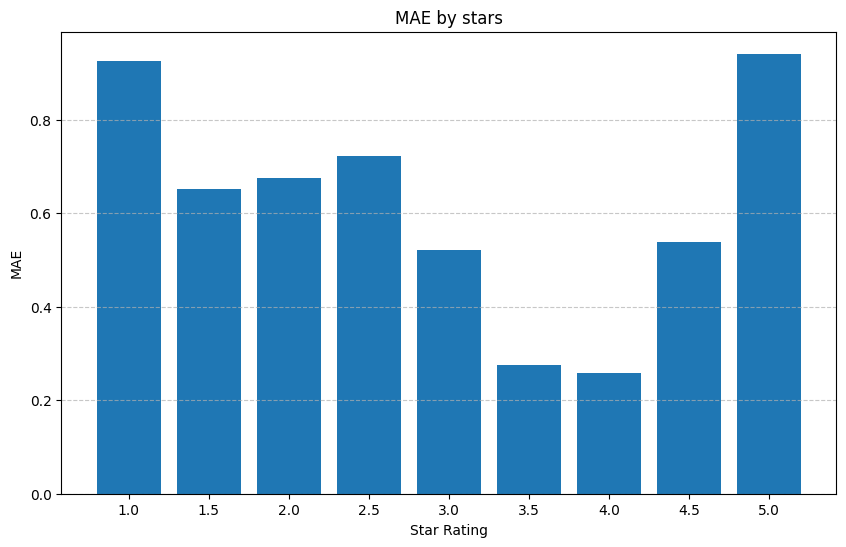

In [11]:
step_size = 0.5
floored_stars_q = (pl.col("actual") / step_size).floor() * step_size
grouped = (
    best_epoch_table.group_by(floored_stars_q.alias("stars"))
    .agg(
        pl.col("abs_error").mean().alias("mae"),
        pl.col("error").pow(2).mean().alias("mse"),
    )
    .sort("stars")
)

plt.figure(figsize=(10, 6))
plt.bar(
    x=grouped["stars"],
    height=grouped["mae"],
    width=0.4,
)
plt.title("MAE by stars")
plt.xlabel("Star Rating")
plt.ylabel("MAE")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks([x/2+1 for x in range(9)]);

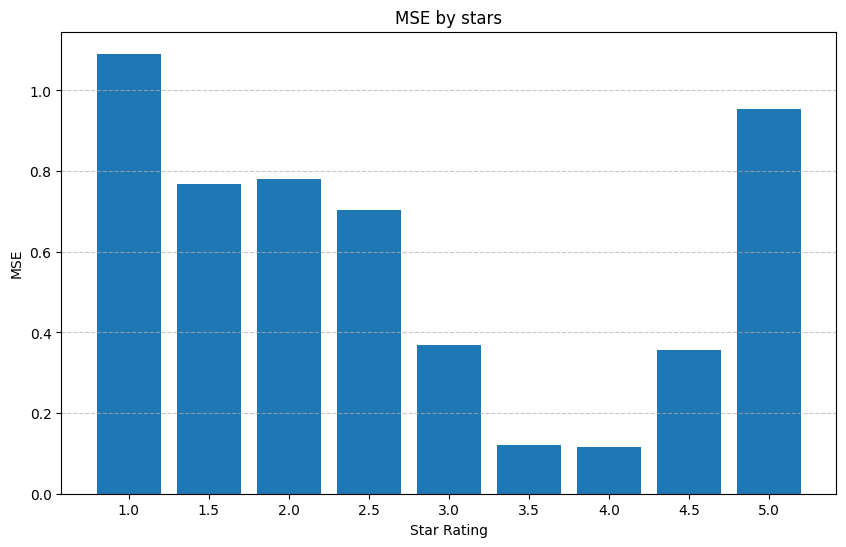

In [12]:
plt.figure(figsize=(10, 6))
plt.bar(
    x=grouped["stars"],
    height=grouped["mse"],
    width=0.4,
)
plt.title("MSE by stars")
plt.xlabel("Star Rating")
plt.ylabel("MSE")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks([x/2+1 for x in range(9)]);

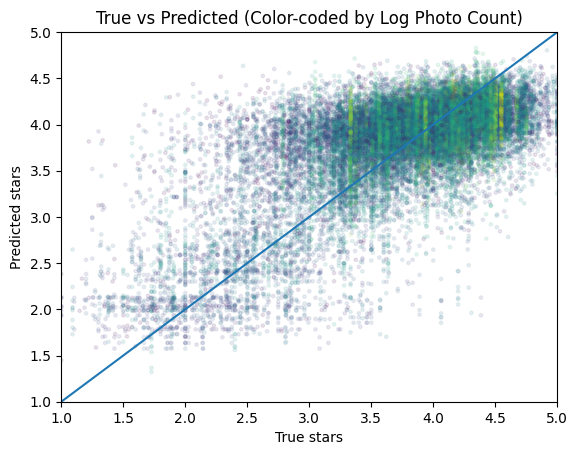

In [13]:
plt.figure()
plt.scatter(
    x=best_epoch_table["actual"],
    y=best_epoch_table["prediction"],
    c=best_epoch_table["business_photo_count"],
    norm=colors.LogNorm(
        vmin=best_epoch_table["business_photo_count"].min(), # type: ignore
        vmax=best_epoch_table["business_photo_count"].max(), # type: ignore
    ),
    cmap='viridis',
    s=6,
    alpha=0.1,
)
plt.plot([1, 5], [1, 5])
plt.xlim(1, 5)
plt.ylim(1, 5)
plt.xlabel("True stars")
plt.ylabel("Predicted stars")
plt.title("True vs Predicted (Color-coded by Log Photo Count)")

None

In [14]:
aggr_by_business = best_epoch_table.group_by("business_id").agg(
    pl.col("abs_error").mean(),
    pl.col("business_photo_count").first(),
    pl.col("business_review_count").first(),
)

aggr_by_business

business_id,abs_error,business_photo_count,business_review_count
str,f64,u32,i64
"""DeVlppoc8dPBhOCPrm4wmg""",0.238147,15,895
"""gP_oWJykA2RocIs_GurKWQ""",0.902483,6,623
"""iA0csH3u6Ug1x1Pt0-El-A""",0.418206,19,219
"""HgVrP7BAkhyuUxKRaQGGsw""",0.173475,7,37
"""O1yOaZXGvAVb7d2YXL5L-A""",0.254752,4,113
…,…,…,…
"""-fEZQoE-pdN_uvXdr3WR_g""",1.083066,5,92
"""5Z-z5-ZYmrJ8RW_oOpp9lQ""",0.172158,1,70
"""nb_gbA9ZDT_t4QedmqOw0A""",0.504581,6,80


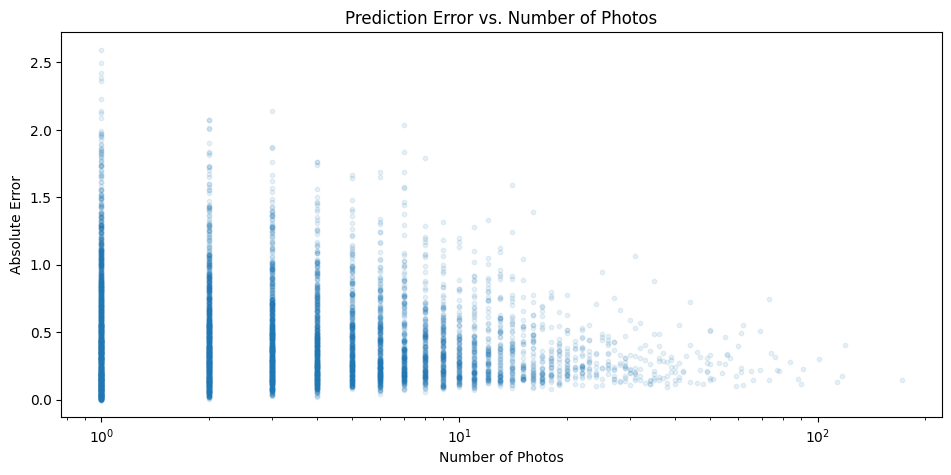

In [15]:
plt.figure(figsize=(25, 5))
plt.subplot(1, 2, 1)
plt.scatter(
    x=aggr_by_business["business_photo_count"],
    y=aggr_by_business["abs_error"],
    alpha=0.1,
    s=10,
)
plt.title("Prediction Error vs. Number of Photos")
plt.xlabel("Number of Photos")
plt.ylabel("Absolute Error")
plt.xscale("log")

None

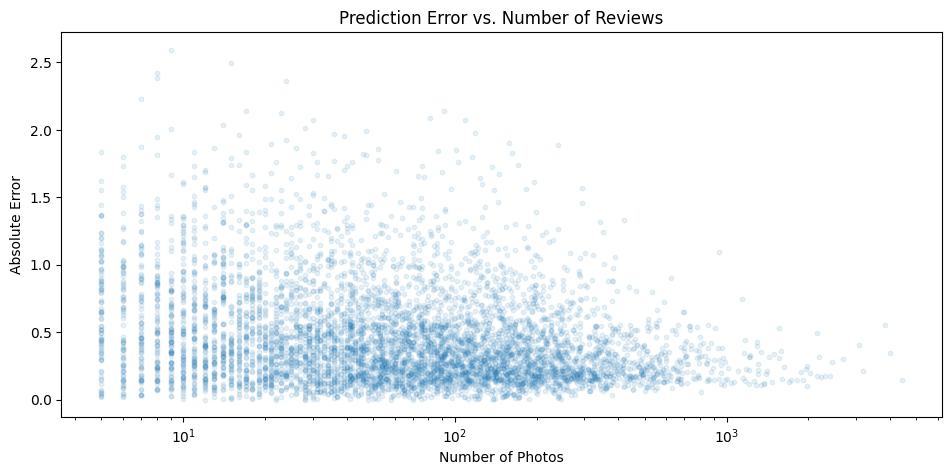

In [16]:
plt.figure(figsize=(25, 5))
plt.subplot(1, 2, 1)
plt.scatter(
    x=aggr_by_business["business_review_count"],
    y=aggr_by_business["abs_error"],
    alpha=0.1,
    s=10,
)
plt.title("Prediction Error vs. Number of Reviews")
plt.xlabel("Number of Photos")
plt.ylabel("Absolute Error")
plt.xscale("log")
None